In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from math import ceil
df = pd.DataFrame

In [2]:
def get_df(stockval, start , end):
    global df
    df = web.DataReader(stockval, data_source="yahoo", start=start, end=end )
    df['Date'] = pd.to_datetime(df.index)
    return df.set_index('Date')

In [16]:
df = get_df('XYF', '12-05-2020','12-05-2022')

In [17]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-04,2.39,2.30,2.39,2.34,27400,2.34
2020-12-07,2.36,2.23,2.36,2.28,33900,2.28
2020-12-08,2.34,2.21,2.23,2.23,36400,2.23
2020-12-09,2.29,2.17,2.19,2.23,20700,2.23
2020-12-10,2.40,2.17,2.17,2.40,13500,2.40


In [5]:
def prediction(ticker):
    data = df.filter(['Close'])
    dataset = data.values
    training_data_len = ceil(len(dataset) * .8)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    train_data = scaled_data[0:training_data_len, :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60: i, 0])
        y_train.append(train_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train , (x_train.shape[0], x_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60,len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean( predictions - y_test )** 2 )
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    fig = plt.figure(figsize = (11, 5))
    plt.title('Model')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.legend(['Train', 'Value', 'Predictions'],loc='lower right')
    apple_quote = df
    new_df = apple_quote.filter(['Close'])
    last_60_days = new_df[-60:].values
    last_60_days_scaled = scaler.transform(last_60_days)
    X_test = []
    X_test.append(last_60_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    txt=f"{pred_price}"
    plt.figtext(0.5, 0.001, txt, wrap=True, horizontalalignment='center', fontsize=12)
    return fig

260/260 [==============================] - 12s 31ms/step - loss: 0.0132


C:\Users\Shubham\AppData\Local\Temp\ipykernel_12012\1209094888.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


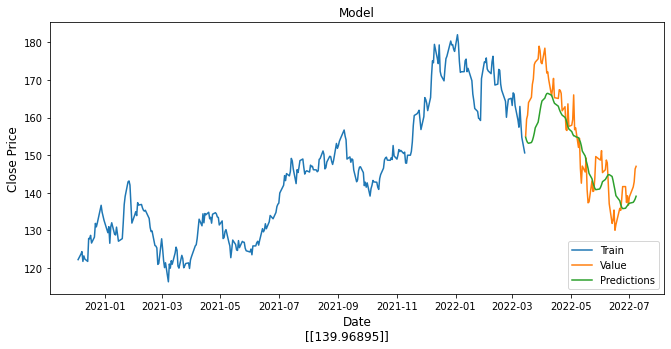

In [9]:
val = prediction(1)
# val